<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  Demonstrate detection of adversarial samples using ART  </b></font></font></th>
   </tr> 
</table>

In this notebook we demonstrate the detection of adversarial samples using ART. Our classifier will be a **ResNet** architecture for the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) image data set.


## Contents

1.	[Loading prereqs and data](#prereqs)
2.  [Evaluating the classifier](#classifier)
3.  [Training the detector](#train_detector)
4.  [Evaluating the detector](#detector)
5.  [Crazy stuff](#crazy)

<a id="prereqs"></a>
## 1. Loading prereqs and data

In [119]:
import warnings
warnings.filterwarnings('ignore')

from keras.models import load_model

from art.config import ART_DATA_PATH
from art.utils import load_dataset, get_file
from art.classifiers import KerasClassifier
from art.attacks import FastGradientMethod
from art.detection import BinaryInputDetector

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

Load the CIFAR10 data set and class descriptions:

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')

n_train = 200
n_test = 200
n_jobs = 4
x_train = x_train[:n_train]
y_train = y_train[:n_train]
x_test = x_test[:n_test]
y_test = y_test[:n_test]

class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

<a id="classifier"></a>
## 2. Evaluating the classifier

Load the pre-trained classifier (a ResNet architecture):

In [3]:
path = get_file('cifar_resnet.h5',extract=False, path=ART_DATA_PATH,
                url='https://www.dropbox.com/s/ta75pl4krya5djj/cifar_resnet.h5?dl=1')
classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False, 
                             preprocessing=(0.5, 1))

In [4]:
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

Evaluate the classifier on the first n_test test images:

In [5]:
x_test_pred = np.argmax(classifier.predict(x_test[:n_test]), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test[:n_test], axis=1))

print("Original test data (first n_test images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(n_test-nb_correct_pred))

Original test data (first n_test images):
Correctly classified: 191
Incorrectly classified: 9


For illustration purposes, look at the first 9 images. (In brackets: true labels.)

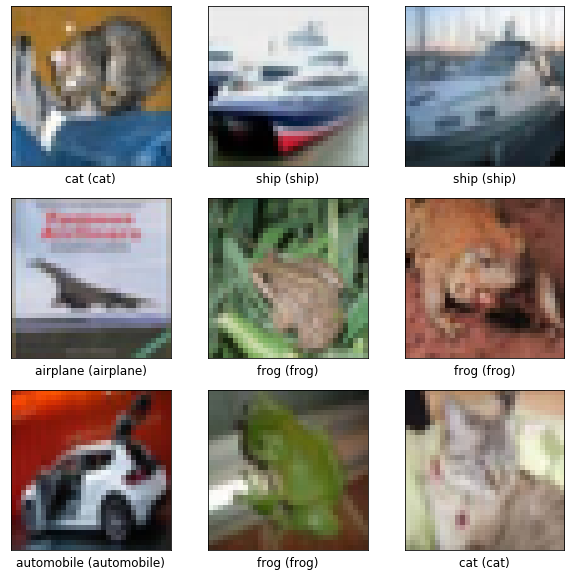

In [6]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_pred[i]], class_descr[np.argmax(y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(x_test[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

Generate some adversarial samples:

In [120]:
attacker = FastGradientMethod(classifier, eps=0.05)
x_test_adv = attacker.generate(x_test[:n_test]) # this takes about two minutes

Evaluate the classifier on n_test adversarial samples:

In [121]:
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:n_test], axis=1))

print("Adversarial test data (first n_test images):")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(n_test-nb_correct_adv_pred))

Adversarial test data (first n_test images):
Correctly classified: 44
Incorrectly classified: 156


Now plot the adversarial images and their predicted labels (in brackets: true labels).

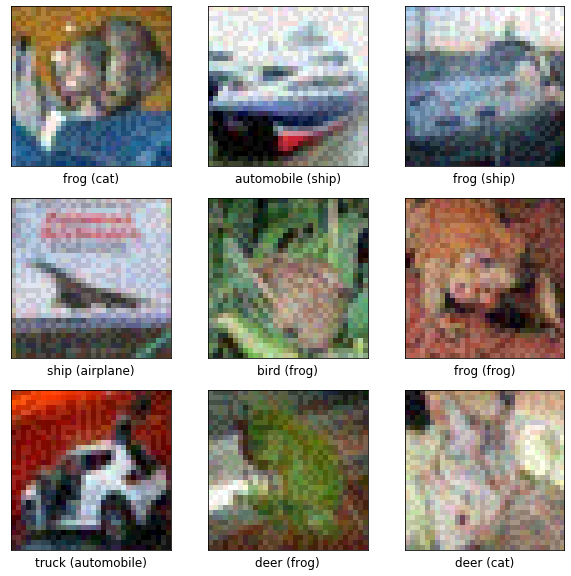

In [122]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_adv_pred[i]], class_descr[np.argmax(y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(x_test_adv[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

<a id="train_detector"></a>
## 3. Training the detector

Load the detector model (which also uses a ResNet architecture):

In [123]:
path = get_file('BID_eps=0.05.h5',extract=False, path=ART_DATA_PATH,
                url='https://www.dropbox.com/s/cbyfk65497wwbtn/BID_eps%3D0.05.h5?dl=1')
detector_model = load_model(path)
detector_classifier = KerasClassifier(clip_values=(-0.5, 0.5), model=detector_model, use_logits=False)
detector = BinaryInputDetector(detector_classifier)

In [124]:
detector_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

To train the detector:
- we expand our training set with adversarial samples
- we label the data with 0 (original) and 1 (adversarial)

In [125]:
x_train_adv = attacker.generate(x_train)
nb_train = x_train.shape[0]

x_train_detector = np.concatenate((x_train, x_train_adv), axis=0)
y_train_detector = np.concatenate((np.array([[1,0]]*nb_train), np.array([[0,1]]*nb_train)), axis=0)

Perform the training:

In [126]:
detector.fit(x_train_detector, y_train_detector, nb_epochs=20, batch_size=20)

Epoch 1/20
20/20 [==============================] - 30s 2s/step - loss: 0.0060 - accuracy: 1.0000
Epoch 2/20
20/20 [==============================] - 10s 479ms/step - loss: 0.0061 - accuracy: 1.0000
Epoch 3/20
20/20 [==============================] - 11s 560ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 4/20
20/20 [==============================] - 11s 575ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 5/20
20/20 [==============================] - 11s 529ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 6/20
20/20 [==============================] - 11s 555ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 7/20
20/20 [==============================] - 14s 691ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 8/20
20/20 [==============================] - 11s 574ms/step - loss: 0.0090 - accuracy: 0.9975
Epoch 9/20
20/20 [==============================] - 10s 497ms/step - loss: 0.0075 - accuracy: 0.9975
Epoch 10/20
20/20 [==============================] - 9s 462ms/step - loss: 0.0235 - accuracy: 

<a id="detector"></a>
## 4. Evaluating the detector

Apply the detector to the adversarial test data:

In [127]:
flag_adv = np.sum(np.argmax(detector.predict(x_test_adv), axis=1) == 1)

print("Adversarial test data (first n_test images):")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(n_test - flag_adv))

Adversarial test data (first n_test images):
Flagged: 200
Not flagged: 0


Apply the detector to the first n_test original test images:

In [128]:
flag_original = np.sum(np.argmax(detector.predict(x_test[:n_test]), axis=1) == 1)

print("Original test data (first n_test images):")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(n_test - flag_original))

Original test data (first n_test images):
Flagged: 200
Not flagged: 0


Evaluate the detector for different attack strengths `eps`
(**Note**: for the training of detector, `eps=0.05` was used)

In [129]:
eps_range = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
nb_flag_adv = []
nb_missclass = []
all_x_test_adv = {}

for eps in eps_range:
    if eps > 0:
        attacker.set_params(**{'eps': eps})
        x_test_adv = attacker.generate(x_test[:n_test])
    else:
        x_test_adv = x_test
    all_x_test_adv[eps] = x_test_adv
    nb_flag_adv += [np.sum(np.argmax(detector.predict(x_test_adv), axis=1) == 1)]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test[:n_test],
                                                                                           axis=1))]
    
eps_range = eps_range
nb_flag_adv = nb_flag_adv
nb_missclass = nb_missclass

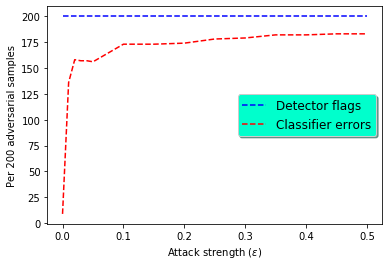

In [130]:
fig, ax = plt.subplots()
ax.plot(eps_range, nb_flag_adv, 'b--', label='Detector flags')
ax.plot(eps_range, nb_missclass, 'r--', label='Classifier errors')

legend = ax.legend(loc='center right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength ($\\varepsilon$)')
plt.ylabel('Per %d adversarial samples' % n_test)
plt.show()

<a id="crazy"></a>
## 5. Crazy stuff

Now let's build a detector which simply looks at the intermediate activations of the host model. The feature vector of our detector will simply be a `FeatureUnion` of PCA transforms of these intermediate activations. The detector can run in both `supervised` and `unsupervised` modes, depending on whether `y` is provided or not during fitting. Everything will be done using `sklearn`

In [131]:
import typing

from sklearn.decomposition import PCA
from sklearn.base import clone, BaseEstimator, ClassifierMixin
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegressionCV

import keras


class SklearnDetector(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=20, random_state=None, skip_layer_names=None):
        super(SklearnDetector, self).__init__()
        self.n_components = n_components
        self.random_state = random_state
        self.skip_layer_names = skip_layer_names
        
    def _skip_layer(self, layer):
        """
        Decides where layer should be included or excluded in analysis
        """
        bad_names = self.skip_layer_names
        if bad_names is None:
            bad_names = ["input", "flatten", "dropout", "add", "activation",
                         "classifier", "reshape", "concat"]
        layer_name = layer.name.lower()
        for bad_name in  bad_names:
            if bad_name in layer_name:
                return True
        else:
            return False

    def _get_classifier_output_tensors(self):
        layer_names = []
        outputs = []
        for layer in classifier_model.layers:
            if not self._skip_layer(layer):
                layer_names.append(layer.name)
                outputs.append(layer.output)
        self.layer_names = layer_names
        return outputs
        
    def _build_classifier_activation_model(self):
        """
        Build model for producing intermediate activations of the host classifier.
        """
        outputs = self._get_classifier_output_tensors()
        self.classifier_activation_model = keras.models.Model(input=classifier_model.input,
                                                              outputs=outputs)

    def _build_layer_pcas(self):
        """
        Build pca model for each intermediate activation layer of host classifier.
        """
        self.pcas = [PCA(n_components=self.n_components, random_state=self.random_state)
                     for _ in self.layer_names]

    def _build(self):
        self._build_classifier_activation_model()
        self._build_layer_pcas()

    def _get_classifier_activations(self, X, ravel=True) -> typing.List[np.array]:
        """
        Get the activation of each intermediate layer of the host classifier.
        """
        classifier_activations = self.classifier_activation_model.predict(X)
        if isinstance(classifier_activations, np.ndarray):
            # keras eats up dimension 0 of model output if model has only one ouput tensor!
            classifier_activations = [classifier_activations]
        if ravel:
            classifier_activations = [Z.reshape((len(Z), -1)) for Z in classifier_activations]
        return classifier_activations
    
    def _transform(self, classifier_activations):
        codes = []
        for pca, Z in zip(self.pcas, classifier_activations):
            codes.append(pca.transform(Z))
        return np.concatenate(codes, axis=1)

    def transform(self, X):
        """
        Get dimensionality-reduced intermediate activations of host classifier.
        """
        classifier_activations = self._get_classifier_activations(X)
        return self._transform(classifier_activations)
    
    def fit(self, X, y=None):
        """
        y: ndarray, optional (default None)
            If provided, we will, the detector will be a logistic-regression model (i.e supervised).
            Otherwise, the detector will be a one-class SVM (i.e unsupervided).
        """
        self._build()
        classifier_activations = self._get_classifier_activations(X)
        for classifier_layer_pca, Z in zip(self.pcas, classifier_activations):
            classifier_layer_pca.fit(Z)
        codes = self._transform(classifier_activations)

        if y is None:
            self.final = OneClassSVM()
        else:
            self.final = LogisticRegressionCV(cv=3, random_state=self.random_state)
        self.final.fit(codes, y)
        return self
    
    def predict(self, X):
        codes = self.transform(X)
        return self.final.predict(codes)

In [132]:
# can things be simplified ?

class SklearnDetectorLastHiddenLayer(SklearnDetector):
    """
    Only use activations from last hidden layer of host classifier
    """

    def _build_classifier_activation_model(self):
        outputs = self._get_classifier_output_tensors()
        self.layer_names = self.layer_names[-1:]
        outputs = outputs[-1:]
        self.classifier_activation_model = keras.models.Model(input=classifier_model.input,
                                                              outputs=outputs)
        
class SklearnDetectorFirstHiddenLayer(SklearnDetector):
    """
    Only use activations from first hidden layer of host classifier
    """
    
    def _build_classifier_activation_model(self):
        outputs = self._get_classifier_output_tensors()
        self.layer_names = self.layer_names[:1]
        outputs = outputs[:1]
        self.classifier_activation_model = keras.models.Model(input=classifier_model.input,
                                                              outputs=outputs)

In [133]:
# fit our detectors
n_components = 10
y_detector_flat = 2 * y_train_detector.argmax(1) - 1
my_detectors = {}
my_detectors["supervised"] = SklearnDetector(n_components=n_components).fit(x_train_detector, y_detector_flat)
my_detectors["unsupervised"] = SklearnDetector(n_components=n_components).fit(x_train)
my_detectors["supervised_fhl"] = SklearnDetectorFirstHiddenLayer(
    n_components=2 * n_components).fit(x_train_detector,  y_detector_flat)
my_detectors["unsupervised_fhl"] = SklearnDetectorFirstHiddenLayer(n_components=2 * n_components).fit(x_train)
my_detectors["supervised_lhl"] = SklearnDetectorLastHiddenLayer(
    n_components=2 * n_components).fit(x_train_detector,  y_detector_flat)
my_detectors["unsupervised_lhl"] = SklearnDetectorLastHiddenLayer(n_components=2 * n_components).fit(x_train)

Scores for unsupervised_empty detector
0.00 ==> 0.50
0.01 ==> 0.48
0.02 ==> 0.47
0.03 ==> 0.48
0.04 ==> 0.55
0.05 ==> 0.59
0.10 ==> 0.58
0.15 ==> 0.37
0.20 ==> 0.28
0.25 ==> 0.41
0.30 ==> 0.52
0.35 ==> 0.62
0.40 ==> 0.68
0.45 ==> 0.74
0.50 ==> 0.80


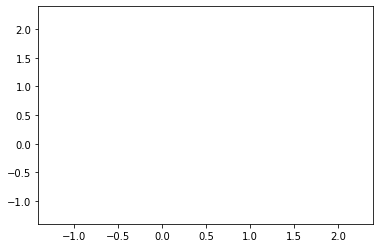

In [440]:
# evaluate the detectors
# scores = {}
from sklearn.metrics import roc_auc_score
for which, my_detector in my_detectors.items():
    if which != "unsupervised_empty":
        continue
    print("Scores for %s detector" % which)
    y_true = y_detector_flat
    if "unsupervised" in which:
        y_true = -y_true
    scores[which] = []
    for eps in all_x_test_adv:
        if eps > 0:
            y_pred = my_detector.predict(np.vstack((x_test, all_x_test_adv[eps])))
            score = roc_auc_score(y_pred, y_true)
        else:
            score = 0.5
        print("%.2f ==> %.2f" % (eps, score))  
        if which not in scores:
            scores[which] = []
        scores[which].append(score)

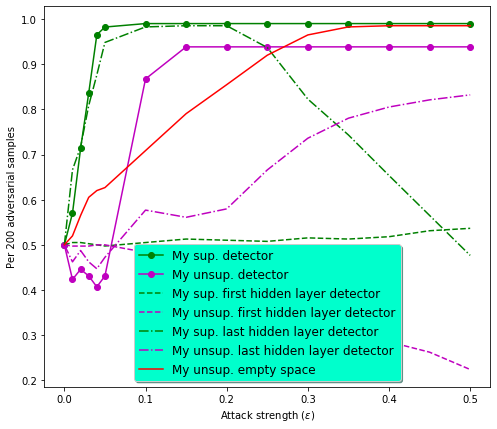

In [395]:
# plot the results
fig, ax = plt.subplots(figsize=(8, 7))
# ax.axhline(n_test, linestyle="--", c="k")
# ax.plot(eps_range, nb_missclass, 'r-o', label='Classifier errors')
# ax.plot(eps_range, nb_flag_adv, 'b-o', label='IBM detector')
ax.plot(eps_range, scores["supervised"], 'g-o', label='My sup. detector')
ax.plot(eps_range, scores["unsupervised"], 'm-o', label='My unsup. detector')
ax.plot(eps_range, scores["supervised_fhl"], 'g--', label='My sup. first hidden layer detector')
ax.plot(eps_range, scores["unsupervised_fhl"], 'm--', label='My unsup. first hidden layer detector')
ax.plot(eps_range, scores["supervised_lhl"], 'g-.', label='My sup. last hidden layer detector')
ax.plot(eps_range, scores["unsupervised_lhl"], 'm-.', label='My unsup. last hidden layer detector')
ax.plot(eps_range, scores["unsupervised_empty"], 'r-', label='My unsup. empty space')

legend = ax.legend(loc='best', shadow=True, fontsize="large")
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength ($\\varepsilon$)')
plt.ylabel('Per %d adversarial samples' % n_test)
plt.show()

We see that:

- IBM's detector solves the task perfectly. However, it will presumably be less accurate on attacks generated via another method
- Our supervised detector solves the task, but struggles with small values of the attack strength ($\varepsilon$).
- Neither the first hidden layer nor the last hidden layer is solely sufficient for detecting adversarial examples. We need all intermediate layer activations to solve the task!

In [145]:
# compute the hidden representations used by our detectors
all_codes = []
which = "unsupervised"
for X in all_x_test_adv.values():
    codes = my_detectors[which].transform(X)
    all_codes.append(codes)
all_codes = np.concatenate(all_codes, axis=0)

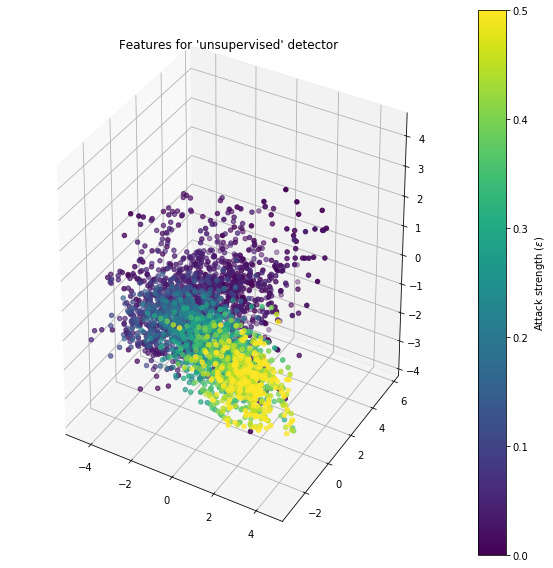

In [146]:
# visualize the hidden representations
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from sklearn.manifold import TSNE

colors = np.concatenate([np.full(len(all_x_test_adv[eps]), eps) for eps in all_x_test_adv])
if False:
    visu = TSNE(n_components=3).fit_transform(all_codes)
else:
    visu = all_codes[:, -10:-7]
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
im = ax.scatter(*visu.T, c=colors)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Attack strength ($\\varepsilon$)");
plt.title("Features for '%s' detector" % which)
plt.tight_layout()

In [147]:
def monte_carlo(model, x, n_iter=100):
    import keras.backend as K
    f = K.function([model.input, K.learning_phase()],
                   [model.output])
    return [f((x, 1))[0] for _ in range(n_iter)]

In [148]:
class UncertaintyDetector(BaseEstimator, ClassifierMixin):
    def __init__(self, random_state=None, mc_n_iter=20):
        super(UncertaintyDetector, self).__init__()
        self.random_state = random_state
        self.mc_n_iter = mc_n_iter
        
    def get_uncertainty(self, x):
        predictions = monte_carlo(classifier_model, x, n_iter=self.mc_n_iter)
        return np.var(predictions, axis=0)
    
    def fit(self, X, y=None):
        if y is None:
            self.final = OneClassSVM()
        else:
            self.final = LogisticRegressionCV(cv=3, random_state=self.random_state)
        
        uncertainty = self.get_uncertainty(X)
        self.final.fit(uncertainty, y)
        return self
        
    def predict(self, X):
        return self.final.predict(self.get_uncertainty(X))
                    

In [149]:
my_detectors["supervised_uncertainty"] = UncertaintyDetector().fit(x_train_detector, y_detector_flat)

In [190]:
clean = x_test.reshape((200, -1))
adv = all_x_test_adv[0.1].reshape((200, -1))
merged = np.concatenate((clean, adv), axis=0)
dist = np.abs(merged[:, None] - clean).max(-1)

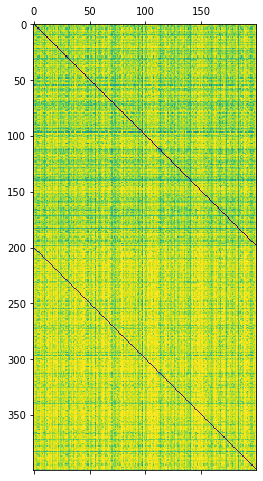

In [191]:
plt.matshow(dist)

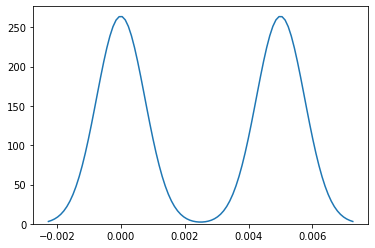

In [278]:
import seaborn as sns
sns.kdeplot((dist <= .01).mean(axis=1))

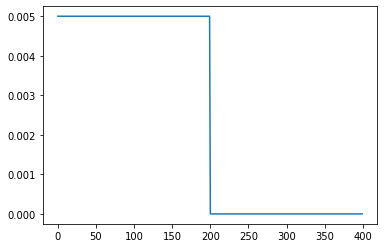

In [279]:
plt.plot((dist <= .01).mean(axis=1))

In [423]:
from sklearn.svm import SVC

class EmptySpaceDetector(BaseEstimator, ClassifierMixin):
    def __init__(self, norm=np.inf, dist_cutoff=None, threshold=0.2, random_state=None):
        super(EmptySpaceDetector, self).__init__()
        self.norm = norm
        self.dist_cutoff = dist_cutoff
        self.threshold = threshold
        self.random_state = random_state
        
    def _pointwise_distance(self, X, X_=None):
        if X_ is None:
            X_ = X
        X = X.reshape((len(X), -1))
        X_ = X_.reshape((len(X_), -1))
        diff = X_[:, None] - X
        if np.isinf(self.norm):
            dist = np.abs(diff).max(axis=-1)
        else:
            dist = linalg.norm(diff, ord=self.norm, axis=-1)
        return dist
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y_train
        if self.dist_cutoff is None:
            dist = self._pointwise_distance(X)
            self.dist_cutoff = dist.mean()
            print(self.dist_cutoff)
        return self
    
    def predict(self, X):
        dist = self._pointwise_distance(self.X_train, X)
        labels = classifier.predict(X).argmax(-1)
        mask = labels[:, None] == self.y_train
        # plt.matshow(dist)
        plt.plot((dist[mask] <= self.dist_cutoff).mean(axis=1))
        y_pred = np.ones(len(X))
        mask = labels
        y_pred[(dist[mask] <= self.dist_cutoff).mean(axis=1) <= self.threshold] = -1
        return y_pred
            

In [438]:
my_detectors["unsupervised_empty"] = EmptySpaceDetector(threshold=.3).fit(x_train, y_train)

0.8395886274509805


196

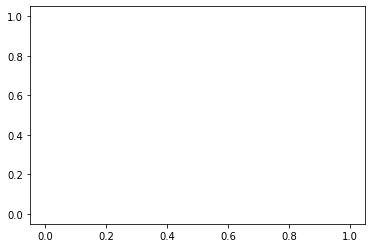

In [442]:
(my_detectors["unsupervised_empty"].predict(np.concatenate((x_test, all_x_test_adv[0.5]), axis=0)) == -1).sum()

0.75 0.1


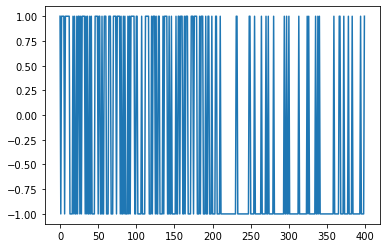

In [329]:
plt.plot(my_detectors["unsupervised_empty"].predict(merged))

In [296]:
merged[:200] - x_train.reshape((200, -1))

array([[ 0.38823529,  0.19607843, -0.05490196, ..., -0.4       ,
        -0.09803922,  0.14901961],
       [ 0.31764706,  0.22745098,  0.18823529, ...,  0.16862745,
         0.2627451 ,  0.21568627],
       [-0.38039216, -0.25490196, -0.12941176, ..., -0.28627451,
        -0.30588235, -0.30196078],
       ...,
       [ 0.67058824,  0.65882353,  0.60392157, ...,  0.34117647,
         0.31764706,  0.29411765],
       [ 0.89019608,  0.8627451 ,  0.87843137, ...,  0.66666667,
         0.64313725,  0.56078431],
       [-0.28235294, -0.3254902 , -0.30196078, ...,  0.39607843,
         0.38431373,  0.32156863]])